# Model of particulate matter dynamics using traffic and weather data

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
import sklearn.metrics as metrics

## Read data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#!ls drive/MyDrive

In [6]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/df_marien_full.csv', parse_dates=['datetime'], index_col='datetime')

In [7]:
df = df.dropna()

In [8]:
num_features = df.drop(columns=['Feinstaub (PM2,5)']).columns
num_features

Index(['q_kfz_mq_hr', 'v_kfz_mq_hr', 'LUFTTEMPERATUR', 'REL_FEUCHTE',
       'NIEDERSCHLAGSHOEHE', 'WINDGESCHWINDIGKEIT', 'SONNENSCHEINDAUER',
       'mean_q', 'min_q', 'max_q', 'std_q', 'skew_q', 'kurt_q', 'mean_v',
       'min_v', 'max_v', 'std_v', 'skew_v', 'kurt_v', 'q_kfz_lag1',
       'q_kfz_lag2', 'q_kfz_lag3', 'q_kfz_lag6', 'q_kfz_lag12', 'q_kfz_lag24',
       'v_kfz_lag1', 'v_kfz_lag2', 'v_kfz_lag3', 'v_kfz_lag6', 'v_kfz_lag12',
       'v_kfz_lag24', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'winddir_cos', 'winddir_sin'],
      dtype='object')

### Linear Regression to check for p-values

In [ ]:
import statsmodels.api as sm

In [ ]:
lm_stats = sm.OLS(df['Feinstaub (PM2,5)'], df.drop(columns=['Feinstaub (PM2,5)']))
results_lm = lm_stats.fit()

In [ ]:
results_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Feinstaub (PM2,5)   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              943.5
Date:                Sun, 18 Dec 2022   Prob (F-statistic):                        0.00
Time:                        23:38:36   Log-Likelihood:                         -25421.
No. Observations:                7837   AIC:                                  5.092e+04
Df Residuals:                    7798   BIC:                                  5.119e+04
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
q_kfz_mq_hr            -0.0040      0.001     -4.936      0.000      -0.006      -0.002
v_kfz_mq_hr             0.0105      0.011      0.981      0.327      -0.011       0.032
LUFTTEMPERATUR          0.0446      0.021      2.117      0.034       0.003       0.086
REL_FEUCHTE             0.0580      0.006      9.200      0.000       0.046       0.070
NIEDERSCHLAGSHOEHE     -0.1340      0.177     -0.757      0.449      -0.481       0.213
WINDGESCHWINDIGKEIT    -0.5463      0.018    -31.148      0.000      -0.581      -0.512
SONNENSCHEINDAUER      -0.0210      0.006     -3.236      0.001      -0.034      -0.008
mean_q                 -0.0035      0.002     -1.547      0.122      -0.008       0.001
min_q                   0.0018      0.007      0.255      0.799      -0.012       0.016
max_q                  -0.0004      0.000     -1.449      0.147      -0.001       0.000
std_q                   0.0185      0.004      4.907      0.000       0.011       0.026
skew_q                 -1.0106      0.301     -3.363      0.001      -1.600      -0.421
kurt_q                  0.0466      0.024      1.919      0.055      -0.001       0.094
mean_v                  0.2946      0.037      8.062      0.000       0.223       0.366
min_v                   0.0830      0.023      3.671      0.000       0.039       0.127
max_v                  -0.0135      0.017     -0.769      0.442      -0.048       0.021
std_v                   0.3603      0.116      3.118      0.002       0.134       0.587
skew_v                 -1.8998      0.372     -5.100      0.000      -2.630      -1.170
kurt_v                  0.2286      0.091      2.517      0.012       0.051       0.407
q_kfz_lag1              0.0017      0.001      1.749      0.080      -0.000       0.004
q_kfz_lag2              0.0020      0.001      1.983      0.047    2.26e-05       0.004
q_kfz_lag3          -9.632e-05      0.001     -0.146      0.884      -0.001       0.001
q_kfz_lag6              0.0006      0.000      1.652      0.099      -0.000       0.001
q_kfz_lag12             0.0006      0.000      2.000      0.046    1.29e-05       0.001
q_kfz_lag24         -7.459e-05      0.000     -0.208      0.835      -0.001       0.001
v_kfz_lag1             -0.0126      0.012     -1.016      0.310      -0.037       0.012
v_kfz_lag2             -0.0097      0.012     -0.783      0.434      -0.034       0.015
v_kfz_lag3              0.0004      0.011      0.035      0.972      -0.021       0.021
v_kfz_lag6             -0.0190      0.008     -2.238      0.025      -0.036      -0.002
v_kfz_lag12            -0.0260      0.008     -3.264      0.001      -0.042      -0.010
v_kfz_lag24            -0.0284      0.008     -3.584      0.000      -0.044     

In [ ]:
lm_out = results_lm.pvalues[results_lm.pvalues>0.1].index
lm_out

Index(['v_kfz_mq_hr', 'NIEDERSCHLAGSHOEHE', 'mean_q', 'min_q', 'max_q',
       'max_v', 'q_kfz_lag3', 'q_kfz_lag24', 'v_kfz_lag1', 'v_kfz_lag2',
       'v_kfz_lag3', 'hour_cos'],
      dtype='object')

### Pipelines

In [9]:
num_transformer = Pipeline(
    steps=[
        # ('imputer', SimpleImputer(missing_values=np.nan, strategy="mean")),
        ('scaler', MinMaxScaler())
        # ('scaler', StandardScaler())
        # preprocessing.PowerTransformer(method='box-cox', standardize=False)
    ])

column_transformer = ColumnTransformer(
    transformers=[
        ('num_trans', num_transformer, num_features)
    ], remainder='drop'
)

#### train-test split

In [10]:
X = df.drop(columns=['Feinstaub (PM2,5)'])
y = df['Feinstaub (PM2,5)']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

#### Linear Regression

In [11]:
lm_pipeline = Pipeline(
    [
        ('col_trans', column_transformer),
        ('model', LinearRegression())
    ])

hyperparams_lm = {
    'col_trans__num_trans__scaler': [MinMaxScaler(), StandardScaler()],
}

In [32]:
lm_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['q_kfz_mq_hr', 'v_kfz_mq_hr', 'LUFTTEMPERATUR', 'REL_FEUCHTE',
       'NIEDERSCHLAGSHOEHE', 'WINDGESCHWINDIGKEIT', 'SONNENSCHEINDAUER',
       'mean_q', 'min_q', 'max_q', 'std_q', 'skew_q', 'kurt_q', 'mean_v',
       'min_v', 'max_v', 'std_v', 'skew_v', 'kurt_v', 'q_kfz_lag1',
       'q_kfz_lag2', 'q_kfz_lag3', 'q_kfz_lag6', 'q_kfz_lag12', 'q_kfz_lag24',
       'v_kfz_lag1', 'v_kfz_lag2', 'v_kfz_lag3', 'v_kfz_lag6', 'v_kfz_lag12',
       'v_kfz_lag24', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'winddir_cos', 'winddir_sin'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [33]:
gs_lm = GridSearchCV(lm_pipeline, hyperparams_lm, cv = 5, verbose=True)
gs_lm.fit(Xtrain, ytrain)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('num_trans',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['q_kfz_mq_hr', 'v_kfz_mq_hr', 'LUFTTEMPERATUR', 'REL_FEUCHTE',
       'NIEDERSCHLAGSHOEHE', 'WINDGESCHWINDIGKEIT', 'SONNENSCHEINDAUER',
       'mean_q', 'min_q', 'max_q', 'std_q', 'skew_q', 'kurt_q', 'mean_v',
       'min_v', 'max_v'...
       'q_kfz_lag2', 'q_kfz_lag3', 'q_kfz_lag6', 'q_kfz_lag12', 'q_kfz_lag24',
       'v_kfz_lag1', 'v_kfz_lag2', 'v_kfz_lag3', 'v_kfz_lag6', 'v_kfz_lag12',
       'v_kfz_lag24', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'winddir_cos', 'winddir_sin'],
      dtype='object

In [34]:
ypred_lm = lm_pipeline.predict(Xtest)
print("train score: %.4f" % lm_pipeline.score(Xtrain, ytrain))
print("test score: %.4f" % lm_pipeline.score(Xtest, ytest))

train score: 0.2915
test score: 0.2751


In [35]:
ypred_lm_gs = gs_lm.predict(Xtrain)
print(gs_lm.score(Xtrain, ytrain), gs_lm.score(Xtest, ytest))
print(gs_lm.best_params_)

0.29151669680923487 0.2750924423476272
{'col_trans__num_trans__scaler': MinMaxScaler()}


In [36]:
gs_lm = GridSearchCV(
            lm_pipeline,
            hyperparams_lm,
            return_train_score=True,
            cv = 5,
            refit=True,
            verbose=False
            )
gs_lm.fit(Xtrain, ytrain)
print(gs_lm.score(Xtrain, ytrain), gs_lm.score(Xtest, ytest))

0.29151669680923487 0.2750924423476272


In [37]:
gs_lm.best_score_, gs_lm.cv_results_['mean_train_score'][0], gs_lm.cv_results_['mean_test_score']

(0.27523092584251296, 0.2929035350656346, array([0.27523093, 0.27523093]))

In [38]:
gs_lm.cv_results_

{'mean_fit_time': array([0.0273252 , 0.02534599]),
 'std_fit_time': array([0.00977696, 0.00997102]),
 'mean_score_time': array([0.00844603, 0.00715203]),
 'std_score_time': array([0.00289134, 0.0027673 ]),
 'param_col_trans__num_trans__scaler': masked_array(data=[MinMaxScaler(), StandardScaler()],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'col_trans__num_trans__scaler': MinMaxScaler()},
  {'col_trans__num_trans__scaler': StandardScaler()}],
 'split0_test_score': array([0.29192633, 0.29192633]),
 'split1_test_score': array([0.25945847, 0.25945847]),
 'split2_test_score': array([0.2699716, 0.2699716]),
 'split3_test_score': array([0.29346312, 0.29346312]),
 'split4_test_score': array([0.2613351, 0.2613351]),
 'mean_test_score': array([0.27523093, 0.27523093]),
 'std_test_score': array([0.01470153, 0.01470153]),
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_train_score': array([0.28881297, 0.28881297]),
 'split1_train_sc

#### Polynomial Regression

In [12]:
lm_poly_pipeline = Pipeline(
    [
        ('col_trans', column_transformer),
        ('polyFeat', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),# num_features
        ('model', LinearRegression())
    ])

hyperparams_lm_poly = {
    'col_trans__num_trans__scaler': [MinMaxScaler(), StandardScaler()],
    'polyFeat__interaction_only': [True, False],
    'polyFeat__degree': [1, 2, 3],
    'polyFeat__include_bias': [True, False]
}

In [13]:
#lm_poly_pipeline.get_params()

In [14]:
lm_poly_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['q_kfz_mq_hr', 'v_kfz_mq_hr', 'LUFTTEMPERATUR', 'REL_FEUCHTE',
       'NIEDERSCHLAGSHOEHE', 'WINDGESCHWINDIGKEIT', 'SONNENSCHEINDAUER',
       'mean_q', 'min_q', 'max_q', 'std_q', 'skew_q', 'kurt_q', 'mean_v',
       'min_v', 'max_v', 'std_v', 'skew_v', 'kurt_v', '...
       'q_kfz_lag2', 'q_kfz_lag3', 'q_kfz_lag6', 'q_kfz_lag12', 'q_kfz_lag24',
       'v_kfz_lag1', 'v_kfz_lag2', 'v_kfz_lag3', 'v_kfz_lag6', 'v_kfz_lag12',
       'v_kfz_lag24', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'winddir_cos', 'winddir_sin'],
      dtype='object'))])),
                ('polyFeat', PolynomialFeatures(include_bias=False)),
                ('model'

In [15]:
ypred_poly = lm_poly_pipeline.predict(Xtrain)
print("train score: %.4f" % lm_poly_pipeline.score(Xtrain, ytrain))
print("test score: %.4f" % lm_poly_pipeline.score(Xtest, ytest))

train score: 0.6399
test score: 0.4857


In [16]:
gs_poly = GridSearchCV(lm_poly_pipeline, hyperparams_lm_poly, cv = 5, verbose=True)
gs_poly.fit(Xtrain, ytrain)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('num_trans',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['q_kfz_mq_hr', 'v_kfz_mq_hr', 'LUFTTEMPERATUR', 'REL_FEUCHTE',
       'NIEDERSCHLAGSHOEHE', 'WINDGESCHWINDIGKEIT', 'SONNENSCHEINDAUER',
       'mean_q', 'min_q', 'max_q', 'std_q', 'skew_q', 'kurt_q', 'mean_v',
       'min_v', 'max_v'...
       'month_sin', 'month_cos', 'winddir_cos', 'winddir_sin'],
      dtype='object'))])),
                                       ('polyFeat',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model', LinearRegression())]),
             param_g

In [17]:
ypred_poly_gs = gs_poly.predict(Xtrain)
print(gs_poly.score(Xtrain, ytrain), gs_poly.score(Xtest, ytest))
print(gs_poly.best_params_)

0.6266424746944786 0.46803945653843326
{'col_trans__num_trans__scaler': StandardScaler(), 'polyFeat__degree': 2, 'polyFeat__include_bias': True, 'polyFeat__interaction_only': True}


#### Random Forest

In [ ]:
rf_pipeline = Pipeline(
    steps = [
        ('col_trans', column_transformer),
        ('model', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=10, max_features='sqrt'))
])

hyperparams_rf = {
    #'preprocessor__pipeline-2__simpleimputer__strategy': ['mean', 'median'],
    'model__max_depth': [3, 4, 5, 10, 20, 50], 
    'model__n_estimators': [10, 100, 200, 500, 1000],
    'model__maxfeatures': ['sqrt', 'log2']
}

In [ ]:
rf_pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['q_kfz_mq_hr', 'v_kfz_mq_hr', 'LUFTTEMPERATUR', 'REL_FEUCHTE',
       'NIEDERSCHLAGSHOEHE', 'WINDGESCHWINDIGKEIT', 'SONNENSCHEINDAUER',
       'mean_q', 'min_q', 'max_q', 'std_q', 'skew_q', 'kurt_q', 'mean_v',
       'min_v', 'max_v', 'std_v', 'skew_v', 'kurt_v', '...
       'q_kfz_lag2', 'q_kfz_lag3', 'q_kfz_lag6', 'q_kfz_lag12', 'q_kfz_lag24',
       'v_kfz_lag1', 'v_kfz_lag2', 'v_kfz_lag3', 'v_kfz_lag6', 'v_kfz_lag12',
       'v_kfz_lag24', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_sin', 'month_cos', 'winddir_cos', 'winddir_sin'],
      dtype='object'))])),
                ('model',
                 RandomForestRegressor(max_depth=10, max_features='s

In [ ]:
ypred_rf = rf_pipeline.predict(Xtrain)
print("train score: %.4f" % rf_pipeline.score(Xtrain, ytrain))
print("test score: %.4f" % rf_pipeline.score(Xtest, ytest))

train score: 0.7747
test score: 0.6113


In [ ]:
rf_feature_importance = pd.DataFrame(zip(Xtrain.columns, rf_pipeline.named_steps['model'].feature_importances_), columns=['feature', 'importance'])
rf_feature_importance['abs_value'] = rf_feature_importance['importance'].apply(lambda x: abs(x))
rf_feature_importance = rf_feature_importance.sort_values('abs_value', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

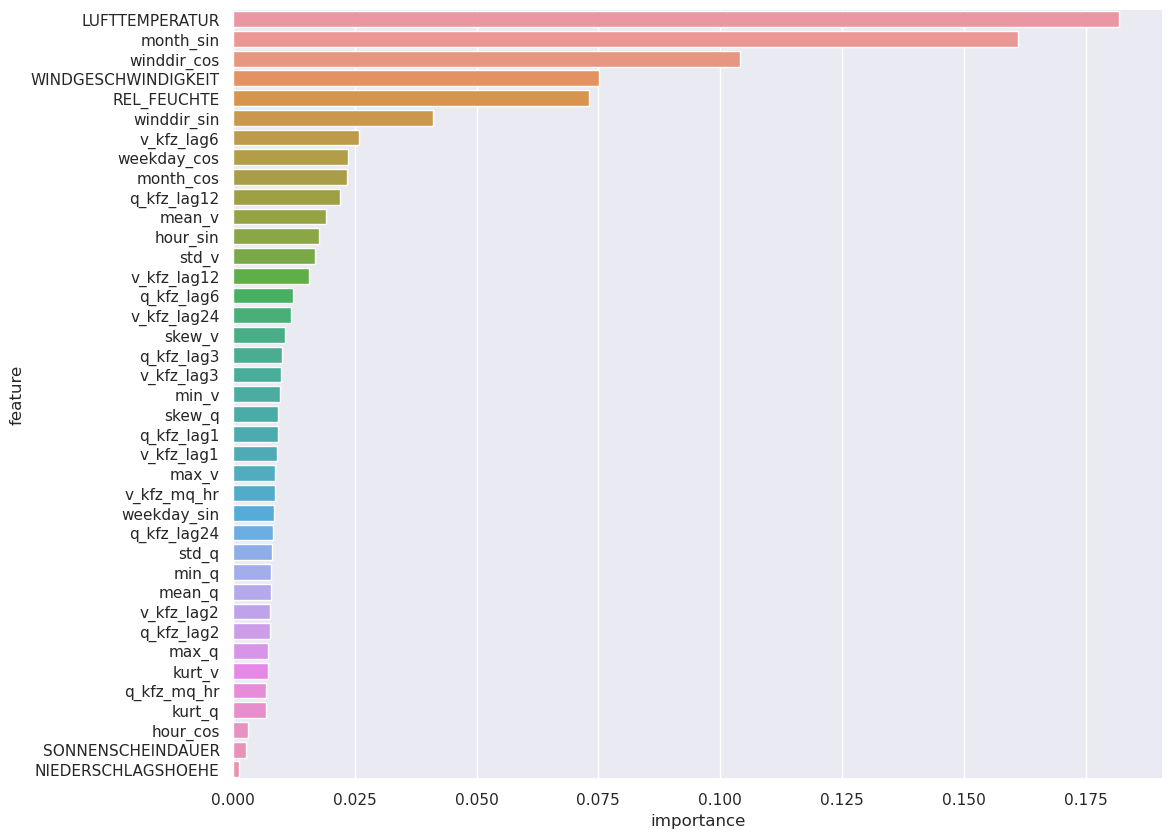

In [ ]:
sns.set(rc={"figure.figsize":(12, 10)})
_ = plt.figure()
img = sns.barplot(y='feature', x='importance', data=rf_feature_importance)
fig = img.get_figure()
fig.savefig('plots/merged/Mariendorfer/RF_feature_importance.png', bbox_inches="tight")

In [ ]:
features_out_rf = rf_feature_importance[rf_feature_importance['importance']<0.015]['feature'].values

In [ ]:
gs_rf = GridSearchCV(rf_pipeline, hyperparams_rf, cv = 5 , verbose=True)
#gs_rf.fit(Xtrain, ytrain)

In [ ]:
ypred_gs_rf = gs_rf.predict(Xtrain)
print(gs_rf.score(Xtrain, ytrain), gs_rf.score(Xtest, ytest))
print(gs_rf.best_params_)

#### Feature Importance / Feature elimination

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
#rfe = RFE(lm_pipeline)
#rfe.fit(Xtrain, ytrain)

In [ ]:
# rfe.support_
# rfe.ranking_

In [ ]:
lm_out

In [ ]:
features_out_rf

In [ ]:
np.intersect1d(lm_out, features_out_rf)

### Functions for testing

In [ ]:
# model_pipes = {
#     'Linear Regression': lm_pipeline,
#     'Polynomial Linear Regression': lm_poly_pipeline,
#     'Random Forest': rf_pipeline}
model_pipes = {
    'Linear Regression': lm_pipeline,
    'Polynomial Linear Regression': lm_poly_pipeline,
    'Random Forest': rf_pipeline,
    'GridSearch Linear Regression': gs_lm,
    'GridSearch Polynomial Linear Regression': gs_poly,
    'GridSearch Random Forest': gs_rf
    }

model_names = model_pipes.keys()

def run_model(model_pipeline, dig=2, use_gs=False):
    '''
    run model
    print train and test accuracy of model
    In case of GridSearch model: print best parameter set
    '''
    print(model_pipeline.upper())
    model_pipes[model_pipeline].fit(Xtrain, ytrain)
    ypred = model_pipes[model_pipeline].predict(Xtest)
    print('accuracy: ', 'train:', round(model_pipes[model_pipeline].score(Xtrain, ytrain), dig),
                        'test:', round(model_pipes[model_pipeline].score(Xtest, ytest), dig))
    if use_gs:
        print(model_pipeline.best_params)
    print('-------------------------------------\n')

In [ ]:
for model in model_names:
    run_model(model)

Linear Regression
LINEAR REGRESSION
accuracy:  train: 0.29 test: 0.28
-------------------------------------

Polynomial Linear Regression
POLYNOMIAL LINEAR REGRESSION
accuracy:  train: 0.64 test: 0.49
-------------------------------------

Random Forest
RANDOM FOREST
accuracy:  train: 0.77 test: 0.61
-------------------------------------

GridSearch Linear Regression
GRIDSEARCH LINEAR REGRESSION
Fitting 5 folds for each of 2 candidates, totalling 10 fits
accuracy:  train: 0.29 test: 0.28
-------------------------------------

GridSearch Polynomial Linear Regression
GRIDSEARCH POLYNOMIAL LINEAR REGRESSION
Fitting 5 folds for each of 32 candidates, totalling 160 fits


KeyboardInterrupt: 